In [11]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier,BaggingClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,recall_score
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

479
cluster
0    479
Name: count, dtype: int64
Bankrupt?
0    374
1    105
Name: count, dtype: int64


<Axes: xlabel='Bankrupt?', ylabel='count'>

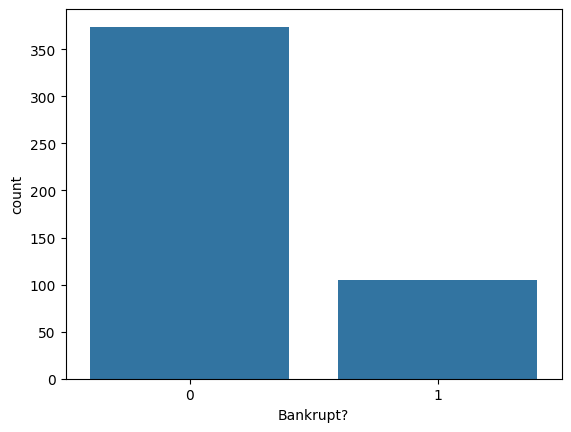

In [12]:
df = pd.read_csv('/Users/wugaoyi/Learning/cs559/cs559_Final_Project/data/subgroub0')

print(df.shape[0])
print(df['cluster'].value_counts())
print(df['Bankrupt?'].value_counts())
sns.countplot(data=df,x='Bankrupt?')

In [13]:
# drop some unrelevant features
X = df.drop(columns=['Index','cluster','Bankrupt?'])
y = df['Bankrupt?']


[(' Persistent EPS in the Last Four Seasons', 0.023551531120966907), (' Net profit before tax/Paid-in capital', 0.022676782457575415), (' Net worth/Assets', 0.02228307500822914), (' Borrowing dependency', 0.020537487984000104), (' Debt ratio %', 0.01989300712917202), (" Net Income to Stockholder's Equity", 0.019172021964316534), (' Per Share Net profit before tax (Yuan ¥)', 0.01838097245187152), (' Net Income to Total Assets', 0.01781731547528144), (' Current Liability to Assets', 0.015849474735021855), (' ROA(A) before interest and % after tax', 0.015407297324885263), (' Interest Expense Ratio', 0.015086608365019082), (' Interest Coverage Ratio (Interest expense to EBIT)', 0.014989462012172024), (' Liability to Equity', 0.014728492540896062), (' Cash/Current Liability', 0.014668375675675565), (' Total assets to GNP price', 0.014407869517037082), (' Interest-bearing debt interest rate', 0.014347233673777986), (' Quick Ratio', 0.014249992025119318), (' Equity to Long-term Liability', 0.

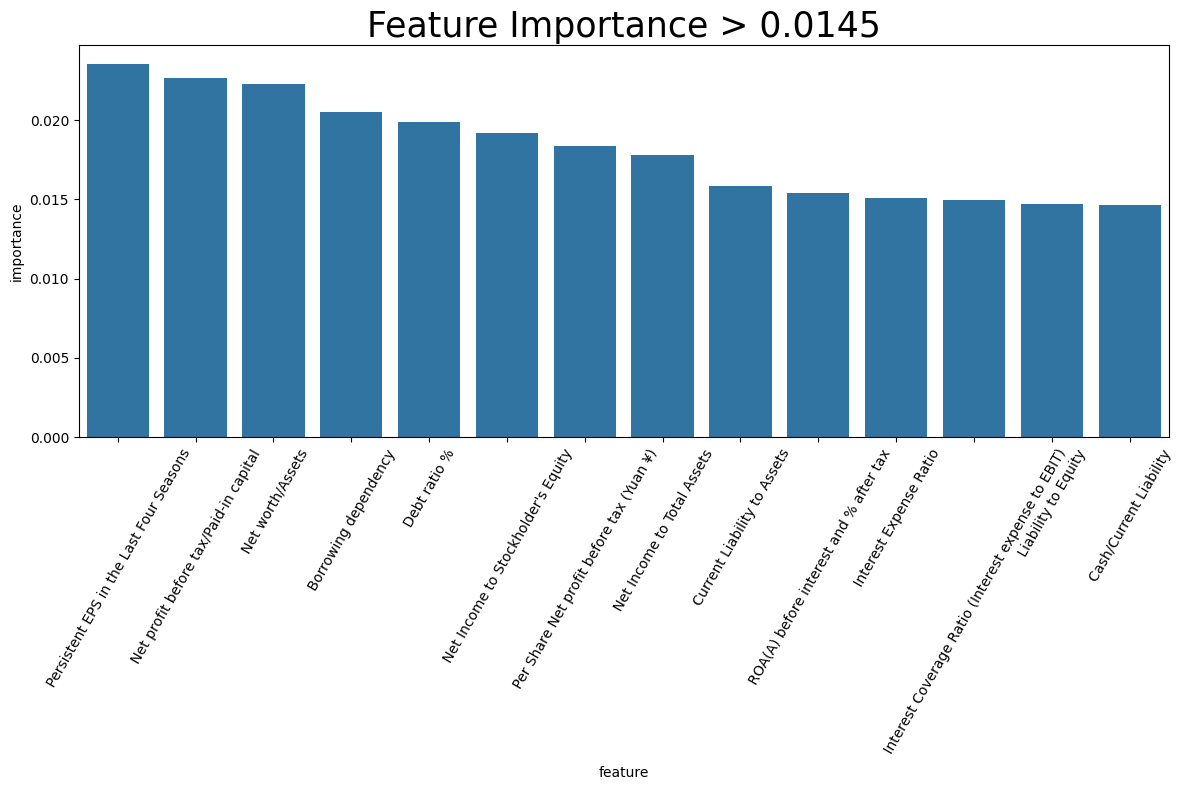

In [14]:
model = ExtraTreesClassifier(n_estimators=100,random_state=100)
model.fit(X,y)
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
list_of_tuples = list(zip(X.columns[sorted_idx],importances[sorted_idx]))
print(list_of_tuples)
feat_importance = pd.DataFrame(list_of_tuples,columns=['feature','importance'])
print(feat_importance)
fig = plt.figure(figsize=(12,8))
fig = sns.barplot(data=feat_importance[feat_importance['importance']>0.0145],x='feature',y='importance')
plt.title('Feature Importance > 0.0145',fontsize=25)
plt.xticks(fontsize=10,rotation=60)
plt.tight_layout()
plt.show()
extract_features = feat_importance[feat_importance['importance']>0.0145]['feature'].tolist()

In [15]:
X_selected = X[extract_features]
print(X_selected.columns)
# X_selected =X


Index([' Persistent EPS in the Last Four Seasons',
       ' Net profit before tax/Paid-in capital', ' Net worth/Assets',
       ' Borrowing dependency', ' Debt ratio %',
       ' Net Income to Stockholder's Equity',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Net Income to Total Assets', ' Current Liability to Assets',
       ' ROA(A) before interest and % after tax', ' Interest Expense Ratio',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Liability to Equity', ' Cash/Current Liability'],
      dtype='object')


In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [17]:
#split the data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=40)
print(X_train.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(383, 14)
Bankrupt?
0    302
1     81
Name: count, dtype: int64
Bankrupt?
0    72
1    24
Name: count, dtype: int64


In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

scaler_dbscan = StandardScaler()
X_sm_scaled = scaler_dbscan.fit_transform(X_sm)

dbscan = DBSCAN(eps=0.5, min_samples=3)
labels = dbscan.fit_predict(X_sm_scaled)

X_clean = X_sm[labels != -1]
y_clean = y_sm[labels != -1]

minority_class_count = np.sum(y_clean == 1)

if len(np.unique(y_clean)) > 1 and minority_class_count > 1:
    k_neighbors = max(1, min(5, minority_class_count - 1))
    smote_final = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote_final.fit_resample(X_clean, y_clean)
    print(f"Applied second SMOTE with k_neighbors = {k_neighbors}")
else:
    print(f"Not enough minority samples ({minority_class_count}) after DBSCAN, skip second SMOTE.")
    X_train, y_train = X_clean, y_clean

print("The shape of training data:", X_train.shape)
print("The distribution of class:\n", pd.Series(y_train).value_counts())

Applied second SMOTE with k_neighbors = 5
The shape of training data: (406, 14)
The distribution of class:
 Bankrupt?
0    203
1    203
Name: count, dtype: int64


In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

estimators = [
    # ('xg',XGBClassifier(random_state=42)),
    ('knn',KNeighborsClassifier()),
    ('bag_svc', BaggingClassifier(
        estimator=SVC(probability=True, class_weight='balanced'),
        n_estimators=10,
        random_state=42
    )),
    ('rf',RandomForestClassifier(class_weight='balanced',random_state=42))
    
]
final_estimator=LogisticRegression()


stack_model = StackingClassifier(estimators=estimators,final_estimator=final_estimator,cv=3)

param_grid = {
    # 'xg__n_estimators': [100,200],
    # 'xg__learning_rate': [0.01,0.1,0.001],
    'knn__n_neighbors':[3,5,7],
    'bag_svc__n_estimators': [5, 10],
    'bag_svc__estimator__C': [1, 10],
}

grid= GridSearchCV(estimator=stack_model,param_grid=param_grid,cv=5,scoring='recall')

grid.fit(X_train,y_train)
probs = grid.predict_proba(X_test)[:, 1]
threshold = 0.5  
preds = (probs >= threshold).astype(int)
# preds=grid.predict(X_test)
cm=confusion_matrix(y_test,preds)
TN, FP, FN, TP = cm.ravel()
acc = TP / (TP + FN)
print(acc)

best_stack = grid.best_estimator_

base_models = dict(best_stack.named_estimators_)

print("\n Base Model acc on Test Set:")
for name, model in base_models.items():
    # predict on X_test
    preds = model.predict(X_test)
    recall = recall_score(y_test, preds)
    cm = confusion_matrix(y_test,preds)
    TN, FP, FN, TP = cm.ravel()
    acc = TP / (TP + FN)
    print(f" {name.upper()} acc: {acc:.4f}")


0.9583333333333334

 Base Model acc on Test Set:
 KNN acc: 0.8750
 BAG_SVC acc: 0.9583
 RF acc: 0.8750


In [20]:
import joblib
import os

# os.makedirs("subgroup0", exist_ok=True)

joblib.dump(extract_features, "./extract_features.pkl")

joblib.dump(scaler, "./scaler.pkl")

joblib.dump(best_stack, "./best_stack_model.pkl")

['./best_stack_model.pkl']